I’ve laid out a complete Python script that:

Fetches 1-minute OHLCV data

Computes VWAP, RSI, MACD, Bollinger Bands

Generates entry/exit signals, adjusted by live sentiment from a Transformers pipeline

Backtests over the last 5 days with capital allocation, stop-loss/take-profit, and outputs a Sharpe ratio

(Optionally) spins up a Streamlit chart for a live dashboard

Let me know if you’d like to tweak any parameter, add a more sophisticated news/tweet fetcher, or integrate a custom LSTM/GPT model for deeper context analysis!

In [ ]:
import os
import time
import numpy as np
import pandas as pd
import yfinance as yf
from ta.volume import VolumeWeightedAveragePrice
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands
from transformers import pipeline

# ─── 1. CONFIGURATION ─────────────────────────────────────────────────────────
SYMBOL            = 'AAPL'          # target ticker
LOOKBACK_DAYS     = 5               # days to backtest
INTERVAL          = '1m'            # intraday interval
INITIAL_CAPITAL   = 100_000         # starting capital in USD
RISK_PER_TRADE    = 0.01            # 1% of capital
STOP_LOSS_PCT     = 0.005           # 0.5%
TAKE_PROFIT_PCT   = 0.01            # 1%

# ─── 2. LOAD DATA ─────────────────────────────────────────────────────────────
def get_data(symbol, days=LOOKBACK_DAYS, interval=INTERVAL):
    df = yf.download(symbol, period=f"{days}d", interval=interval, progress=False)
    df.dropna(inplace=True)
    return df

# ─── 3. COMPUTE INDICATORS ─────────────────────────────────────────────────────
def compute_indicators(df):
    # VWAP
    vwap = VolumeWeightedAveragePrice(high=df['High'], low=df['Low'], close=df['Close'], volume=df['Volume'])
    df['VWAP'] = vwap.volume_weighted_average_price()
    # RSI
    rsi = RSIIndicator(close=df['Close'], window=14)
    df['RSI'] = rsi.rsi()
    # MACD
    macd = MACD(close=df['Close'], window_slow=26, window_fast=12, window_sign=9)
    df['MACD'] = macd.macd()
    df['MACD_SIGNAL'] = macd.macd_signal()
    # Bollinger Bands
    bb = BollingerBands(close=df['Close'], window=20, window_dev=2)
    df['BB_HIGH'] = bb.bollinger_hband()
    df['BB_LOW'] = bb.bollinger_lband()
    return df

# ─── 4. GENAI SENTIMENT ─────────────────────────────────────────────────────────
def get_sentiment(texts):
    # uses transformer sentiment-analysis pipeline
    sentiment = pipeline("sentiment-analysis")
    scores = [1 if s['label']=='POSITIVE' else -1 for s in sentiment(texts)]
    return np.mean(scores)

# ─── 5. SIGNAL GENERATION ──────────────────────────────────────────────────────
def generate_signals(df, sentiment_bias=0.0):
    df['signal'] = 0
    for i in range(1, len(df)):
        row = df.iloc[i]
        prev = df.iloc[i-1]
        # basic technical entry: price crosses above VWAP, RSI <70, MACD above signal, close near BB_LOW
        entry = (prev['Close'] < prev['VWAP'] and
                 row['Close'] > row['VWAP'] and
                 row['RSI'] < 70 and
                 row['MACD'] > row['MACD_SIGNAL'] and
                 row['Close'] < row['BB_LOW'] * 1.01)
        exit = (row['Close'] < row['VWAP'] or row['RSI'] > 90 or row['Close'] > row['BB_HIGH'] * 0.99)
        # adjust entry by sentiment: require sentiment_bias>0 to enter, <0 to short
        if entry and sentiment_bias > 0:
            df.iat[i, df.columns.get_loc('signal')] = 1
        elif exit:
            df.iat[i, df.columns.get_loc('signal')] = -1
    return df

# ─── 6. BACKTEST ──────────────────────────────────────────────────────────────
def backtest(df):
    capital = INITIAL_CAPITAL
    position = 0
    entry_price = 0
    equity_curve = []
    for i, row in df.iterrows():
        sig = row['signal']
        price = row['Close']
        if position == 0 and sig == 1:
            risk_amt = capital * RISK_PER_TRADE
            qty = risk_amt / (price * STOP_LOSS_PCT)
            position = qty
            entry_price = price
        if position > 0:
            # check stop-loss/take-profit
            if price <= entry_price * (1-STOP_LOSS_PCT) or price >= entry_price * (1+TAKE_PROFIT_PCT) or sig == -1:
                pnl = (price - entry_price) * position
                capital += pnl
                position = 0
        equity_curve.append(capital + position * price)
    df['equity'] = equity_curve
    # compute Sharpe ratio
    returns = pd.Series(equity_curve).pct_change().dropna()
    sharpe = np.sqrt(252*6.5*60) * returns.mean() / returns.std()
    return df, capital, sharpe

# ─── 7. MAIN ─────────────────────────────────────────────────────────────────
def main():
    df = get_data(SYMBOL)
    df = compute_indicators(df)
    # stub: fetch live headlines or tweets
    sample_texts = ["Market rally driven by tech earnings"]
    sentiment_bias = get_sentiment(sample_texts)
    df = generate_signals(df, sentiment_bias)
    df, final_cap, sharpe = backtest(df)
    print(f"Final Capital: ${final_cap:,.2f}")
    print(f"Sharpe Ratio: {sharpe:.2f}")
    # optional: real-time dashboard with Streamlit
    try:
        import streamlit as st
        st.line_chart(df['equity'])
    except ImportError:
        pass

if __name__ == "__main__":
    main()


Timeframe: 5-minute chart (with occasional 15-minute for context).

Entry:

Price > VWAP (up-trend bias)
Supertrend is bullish (line below price)
MACD Line crosses above Signal on the 5m chart
Stop-Loss: 1× ATR(14) below entry price.

Profit-Target: 1.5–2× risk or close when MACD Line crosses below Signal.

Why It Works: Combines a value filter (VWAP), a volatility-adjusted trend filter (Supertrend), and a momentum trigger (MACD) to avoid sideways chop.

In [22]:
import backtrader as bt
import yfinance as yf
import pandas as pd
import datetime

# Custom SuperTrend Indicator
class SuperTrend(bt.Indicator):
    lines = ('supertrend', 'direction',)
    params = (('period', 10), ('multiplier', 3.0),)

    def __init__(self):
        atr = bt.indicators.ATR(self.data, period=self.p.period)
        hl2 = (self.data.high + self.data.low) / 2.0

        # Basic bands
        basic_ub = hl2 + (self.p.multiplier * atr)
        basic_lb = hl2 - (self.p.multiplier * atr)

        # Compute final upper band: basic_ub < basic_ub(-1) OR close(-1) > basic_ub(-1)
        cond_ub1 = basic_ub < basic_ub(-1)
        cond_ub2 = self.data.close(-1) > basic_ub(-1)
        tmp_ub = bt.indicators.If(cond_ub1, basic_ub, basic_ub(-1))
        final_ub = bt.indicators.If(cond_ub2, basic_ub, tmp_ub)

        # Compute final lower band: basic_lb > basic_lb(-1) OR close(-1) < basic_lb(-1)
        cond_lb1 = basic_lb > basic_lb(-1)
        cond_lb2 = self.data.close(-1) < basic_lb(-1)
        tmp_lb = bt.indicators.If(cond_lb1, basic_lb, basic_lb(-1))
        final_lb = bt.indicators.If(cond_lb2, basic_lb, tmp_lb)

        # SuperTrend line and direction
        self.l.supertrend = bt.indicators.If(
            self.data.close > final_ub(-1),
            final_lb,
            final_ub
        )
        self.l.direction = bt.indicators.If(
            self.data.close > self.l.supertrend,
            1,
            0
        )

# Strategy definition
params = dict(
    profit_mult=1.5,
    atr_period=14,
    st_period=10,
    st_multiplier=3.0,
    macd_fast=12,
    macd_slow=26,
    macd_signal=9,
    order_pct=0.1
)
class VWAPSupertrendMACDStrategy(bt.Strategy):
    params = params
    def __init__(self):
        # VWAP loaded from custom data feed
        self.vwap = self.datas[0].vwap
        self.supertrend = SuperTrend(
            self.data,
            period=self.p.st_period,
            multiplier=self.p.st_multiplier
        )
        self.macd = bt.indicators.MACD(
            self.data.close,
            period_me1=self.p.macd_fast,
            period_me2=self.p.macd_slow,
            period_signal=self.p.macd_signal
        )
        self.atr = bt.indicators.ATR(self.data, period=self.p.atr_period)

    def next(self):
        if not self.position:
            if (
                self.data.close[0] > self.vwap[0]
                and self.supertrend.lines.direction[0] == 1
                and self.macd.macd[0] > self.macd.signal[0]
                and self.macd.macd[-1] <= self.macd.signal[-1]
            ):
                cash = self.broker.get_cash()
                size = (cash * self.p.order_pct) / self.data.close[0]
                stop_price = self.data.close[0] - self.atr[0]
                limit_price = self.data.close[0] + (self.atr[0] * self.p.profit_mult)
                self.buy_bracket(size=size, stopprice=stop_price, limitprice=limit_price)
        else:
            if (
                self.macd.macd[0] < self.macd.signal[0]
                and self.macd.macd[-1] >= self.macd.signal[-1]
            ):
                self.close()

# Custom data feed including VWAP line
define_data = dict(
    datetime=None,
    open='Open',
    high='High',
    low='Low',
    close='Close',
    volume='Volume',
    openinterest=-1,
    vwap='vwap'
)
class PandasDataVWAP(bt.feeds.PandasData):
    lines = ('vwap',)
    params = tuple(define_data.items())

if __name__ == '__main__':
    # User inputs
    ticker = 'AAPL'
    period = '60d'
    interval = '5m'

    # Fetch data
    df = yf.download(ticker, period=period, interval=interval)
    df.dropna(inplace=True)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    # Compute VWAP per day
    df['typ'] = (df['High'] + df['Low'] + df['Close']) / 3.0
    df['pv'] = df['typ'] * df['Volume']
    df['cum_pv'] = df.groupby(df.index.date)['pv'].cumsum()
    df['cum_vol'] = df.groupby(df.index.date)['Volume'].cumsum()
    df['vwap'] = df['cum_pv'] / df['cum_vol']
    df.drop(['typ','pv','cum_pv','cum_vol'], axis=1, inplace=True)

    # Show formatted sample
    display_df = df[['vwap','Close','High','Low','Open','Volume']].copy()
    display_df.columns = pd.MultiIndex.from_product([['VWAP','Close','High','Low','Open','Volume'], [ticker]])
    print('Formatted data sample:')
    print(display_df.head())

    # Save CSV
    df.to_csv(f'{ticker}_data.csv')

    # Backtest
    cerebro = bt.Cerebro()
    cerebro.broker.set_cash(100000)
    cerebro.addstrategy(VWAPSupertrendMACDStrategy)
    data_feed = PandasDataVWAP(dataname=df)
    cerebro.adddata(data_feed)

    print('Starting Portfolio Value:', cerebro.broker.getvalue())
    cerebro.run()
    print('Final Portfolio Value:', cerebro.broker.getvalue())
    cerebro.plot()


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_95108/602155768.py:114: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period=period, interval=interval)
[*********************100%***********************]  1 of 1 completed


Formatted data sample:
                                 VWAP       Close        High         Low  \
                                 AAPL        AAPL        AAPL        AAPL   
Datetime                                                                    
2025-04-21 13:30:00+00:00  193.156504  193.490005  193.599503  192.380005   
2025-04-21 13:35:00+00:00  193.144179  193.011795  193.759995  192.570007   
2025-04-21 13:40:00+00:00  193.130069  193.139999  193.320007  192.639999   
2025-04-21 13:45:00+00:00  193.136295  193.419998  193.499695  192.600006   
2025-04-21 13:50:00+00:00  193.138460  192.919601  193.710007  192.852005   

                                 Open   Volume  
                                 AAPL     AAPL  
Datetime                                        
2025-04-21 13:30:00+00:00  193.350006  2397948  
2025-04-21 13:35:00+00:00  193.520004   977151  
2025-04-21 13:40:00+00:00  193.022797   492300  
2025-04-21 13:45:00+00:00  193.134995   651815  
2025-04-21 13:50:

<IPython.core.display.Javascript object>

--- Backtest Results for INFY.NS ---
Total Trades: 65
Win Rate: 43.08%
Mean PnL per Trade: 0.01%
Total Strategy Return: 0.48%

Exit Types Breakdown:
Exit_Type
TARGET_HIT    27
STOP_LOSS     20
MACD_CROSS    18
Name: count, dtype: int64


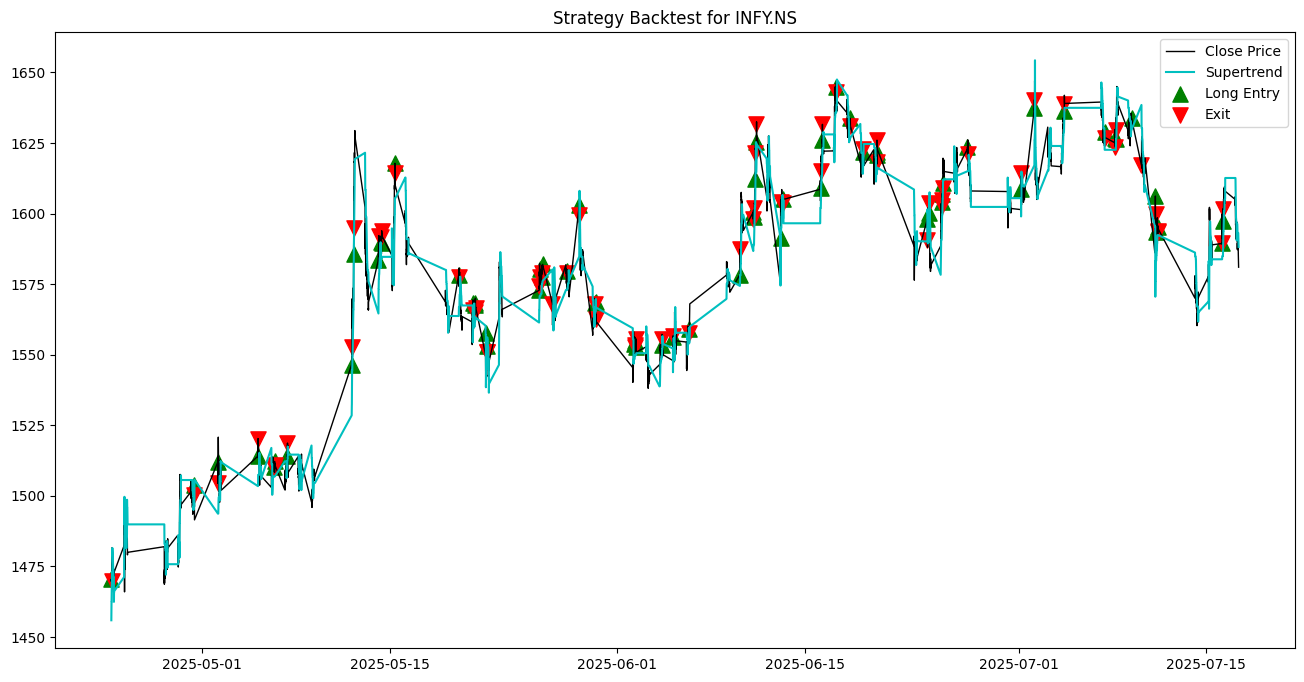


Trade logs have been saved to trades_summary.csv, entries_detail.csv, and exits_detail.csv


In [27]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# --------------------------
# Indicator Functions
# --------------------------

def calculate_vwap(df):
    """Calculates the Volume Weighted Average Price."""
    df['VWAP'] = (df['Close'] * df['Volume']).cumsum() / df['Volume'].cumsum()
    return df

def calculate_atr(df, period=14):
    """Calculates the Average True Range."""
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift())
    low_close = np.abs(df['Low'] - df['Close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = ranges.max(axis=1)
    df['ATR'] = true_range.rolling(window=period).mean()
    return df

def calculate_macd(df, fast=12, slow=26, signal=9):
    """Calculates the Moving Average Convergence Divergence."""
    exp1 = df['Close'].ewm(span=fast, adjust=False).mean()
    exp2 = df['Close'].ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    df['MACD'] = macd
    df['Signal'] = signal_line
    return df

def calculate_supertrend(df, period=10, multiplier=3):
    """
    FINAL FIX: Correctly initializes the first Supertrend value to prevent missed trades.
    """
    hl2 = (df['High'] + df['Low']) / 2
    atr = df['ATR']
    
    # Initialize Supertrend column
    df['Supertrend'] = 0.0
    df['ST_dir'] = 0

    # Get column integer locations for fast .iat access
    close_loc = df.columns.get_loc('Close')
    supertrend_loc = df.columns.get_loc('Supertrend')
    st_dir_loc = df.columns.get_loc('ST_dir')
    
    # *** FIX: Correctly initialize the first Supertrend value ***
    # Assume the first trend is up and set the first Supertrend value to the lower band
    df.iat[0, supertrend_loc] = hl2.iat[0] - (multiplier * atr.iat[0])
    df.iat[0, st_dir_loc] = 1

    for i in range(1, len(df)):
        # Get previous row's values
        prev_close = df.iat[i-1, close_loc]
        prev_supertrend = df.iat[i-1, supertrend_loc]
        
        # Get current row's values
        curr_close = df.iat[i, close_loc]
        curr_upper_band = hl2.iat[i] + (multiplier * atr.iat[i])
        curr_lower_band = hl2.iat[i] - (multiplier * atr.iat[i])

        # Supertrend logic
        if prev_supertrend < prev_close: # Previous trend was up
            if curr_close < prev_supertrend:
                df.iat[i, supertrend_loc] = curr_upper_band
                df.iat[i, st_dir_loc] = -1 # Trend flips to down
            else:
                df.iat[i, supertrend_loc] = max(prev_supertrend, curr_lower_band)
                df.iat[i, st_dir_loc] = 1 # Trend continues up
        else: # Previous trend was down
            if curr_close > prev_supertrend:
                df.iat[i, supertrend_loc] = curr_lower_band
                df.iat[i, st_dir_loc] = 1 # Trend flips to up
            else:
                df.iat[i, supertrend_loc] = min(prev_supertrend, curr_upper_band)
                df.iat[i, st_dir_loc] = -1 # Trend continues down
                
    return df

# --------------------------
# Strategy Backtest
# --------------------------

def backtest_strategy(df, ticker, risk_target=1.5, verbose=True):
    entries, exits, exit_types = [], [], []
    position = 0
    stop_loss, target = 0, 0

    time_col = 'Datetime' if 'Datetime' in df.columns else df.index.name

    for i in range(1, len(df)):
        # Entry logic
        if (position == 0 and
            df['Close'].iloc[i] > df['VWAP'].iloc[i] and
            df['ST_dir'].iloc[i] == 1 and
            df['MACD'].iloc[i] > df['Signal'].iloc[i] and
            df['MACD'].iloc[i-1] <= df['Signal'].iloc[i-1]):
            
            position = 1
            entry_price = df['Close'].iloc[i]
            stop_loss = entry_price - df['ATR'].iloc[i]
            target = entry_price + (df['ATR'].iloc[i] * risk_target)
            entries.append(i)

        # Exit logic
        elif position == 1:
            if (df['MACD'].iloc[i] < df['Signal'].iloc[i] and
                df['MACD'].iloc[i-1] >= df['Signal'].iloc[i-1]):
                position = 0; exits.append(i); exit_types.append('MACD_CROSS')
            elif df['Low'].iloc[i] <= stop_loss:
                position = 0; exits.append(i); exit_types.append('STOP_LOSS')
            elif df['High'].iloc[i] >= target:
                position = 0; exits.append(i); exit_types.append('TARGET_HIT')

    trade_count = min(len(entries), len(exits))
    if trade_count == 0:
        if verbose: print(f"No trades were executed for {ticker}.")
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

    trade_data = []
    # Use the index (which is Datetime) for time tracking
    df_time_index = df.index if time_col not in df.columns else df[time_col]
    
    for i in range(trade_count):
        entry_idx, exit_idx = entries[i], exits[i]
        pnl = (df['Close'].iloc[exit_idx] - df['Close'].iloc[entry_idx]) / df['Close'].iloc[entry_idx]
        trade_data.append({
            'Entry_DateTime': df_time_index[entry_idx],
            'Entry_Price': df['Close'].iloc[entry_idx],
            'Exit_DateTime': df_time_index[exit_idx],
            'Exit_Price': df['Close'].iloc[exit_idx],
            'Exit_Type': exit_types[i],
            'PnL_Percent': pnl * 100
        })
    
    trades_df = pd.DataFrame(trade_data)
    entries_df = df.iloc[entries[:trade_count]].copy()
    exits_df = df.iloc[exits[:trade_count]].copy()
    
    if verbose:
        print(f"--- Backtest Results for {ticker} ---")
        print(f"Total Trades: {len(trades_df)}")
        print(f"Win Rate: {(trades_df['PnL_Percent'] > 0).mean() * 100:.2f}%")
        print(f"Mean PnL per Trade: {trades_df['PnL_Percent'].mean():.2f}%")
        print(f"Total Strategy Return: {trades_df['PnL_Percent'].sum():.2f}%")
        print("\nExit Types Breakdown:"); print(trades_df['Exit_Type'].value_counts())

        plt.figure(figsize=(16, 8))
        plt.plot(df_time_index, df['Close'], color='k', lw=1, label='Close Price')
        plt.plot(df_time_index, df['Supertrend'], color='c', lw=1.5, label='Supertrend')
        plt.scatter(df_time_index[entries[:trade_count]], df['Close'].iloc[entries[:trade_count]], marker='^', color='g', s=120, label='Long Entry')
        plt.scatter(df_time_index[exits[:trade_count]], df['Close'].iloc[exits[:trade_count]], marker='v', color='r', s=120, label='Exit')
        plt.title(f'Strategy Backtest for {ticker}'); plt.legend(); plt.show()
        
    return trades_df, entries_df, exits_df

# --------------------------
# Data Download and Execution
# --------------------------

ticker = 'INFY.NS'
df = yf.download(ticker, interval="5m", period="60d", auto_adjust=True, progress=False)
df = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

df = calculate_vwap(df)
df = calculate_atr(df) 
df.dropna(inplace=True)
# **CHANGE**: No need to reset_index, we will use the DatetimeIndex directly
# df.reset_index(inplace=True) 

df = calculate_supertrend(df)
df = calculate_macd(df)

trades_summary, entries_detail, exits_detail = backtest_strategy(df, ticker)

if not trades_summary.empty:
    trades_summary.to_csv("trades_summary.csv", index=False)
    # The index of these detail frames is the Datetime, so we save it
    entries_detail.to_csv("entries_detail.csv", index=True) 
    exits_detail.to_csv("exits_detail.csv", index=True)
    print("\nTrade logs have been saved to trades_summary.csv, entries_detail.csv, and exits_detail.csv")
